In [1]:
# python -m pip install prophet
# here i will try prophet on the loged data so log(x)

In [38]:
import numpy as np
import pandas as pd
import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.express as px
from datetime import datetime,date
from datetime import timedelta

%matplotlib inline
init_notebook_mode(connected=True)
cf.set_config_file(sharing='private',theme='pearl',offline=True)
#print("Cufflinks Version : {}".format(cf.__version__))

# facebook prophet requires the data to be in 2 colums named ds and y
# ds will be a datetime column with no timezone data and y the label we are forecasting
# ds must NOT be an index like other machine learning algorithms
dfActual = pd.read_csv('./data/BTC-USD.csv')
df = pd.read_csv('./data/btc-usd-max latest.csv', index_col=0, parse_dates=True )
df = df.resample('D').first()
df['price'].fillna(method='ffill', inplace=True)

import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


dynamic_days = 1550

In [45]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [39]:
df.head()

,price,market_cap,total_volume
snapped_at,,,
2013-04-28 00:00:00+00:00,135.30,1.500518e+09,0.0
2013-04-29 00:00:00+00:00,141.96,1.575032e+09,0.0
2013-04-30 00:00:00+00:00,135.30,1.501657e+09,0.0
2013-05-01 00:00:00+00:00,117.00,1.298952e+09,0.0
2013-05-02 00:00:00+00:00,103.43,1.148668e+09,0.0


In [40]:
df['price'].iplot();

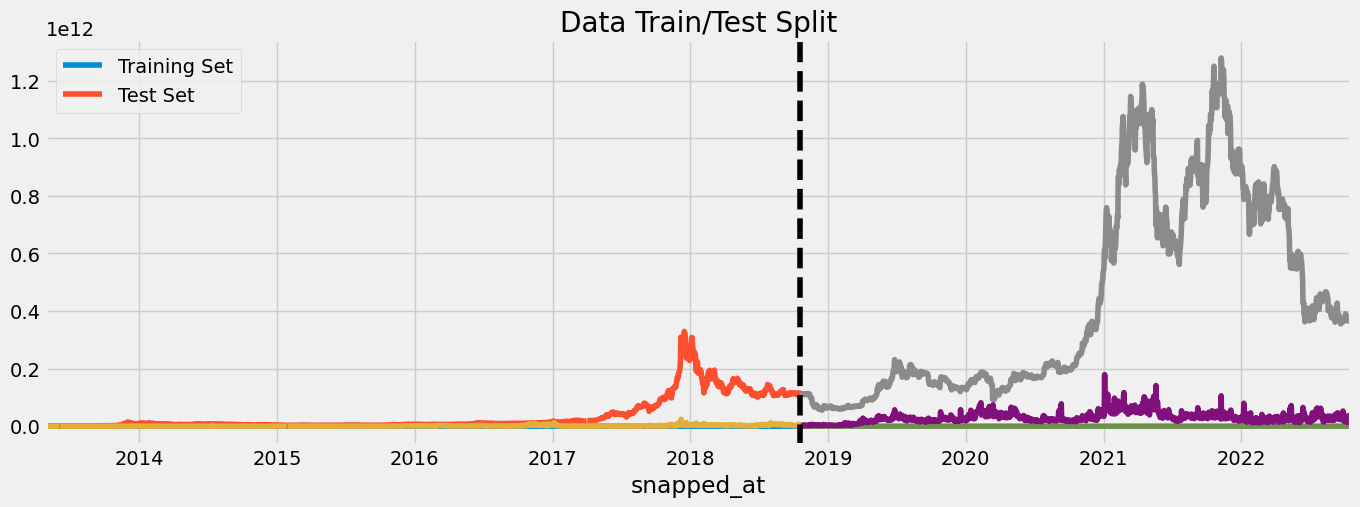

In [44]:
test_period = 4*365
train = df.iloc[:-test_period]
test = df.iloc[-test_period:]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(df.index[-1]-timedelta(days=test_period), color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

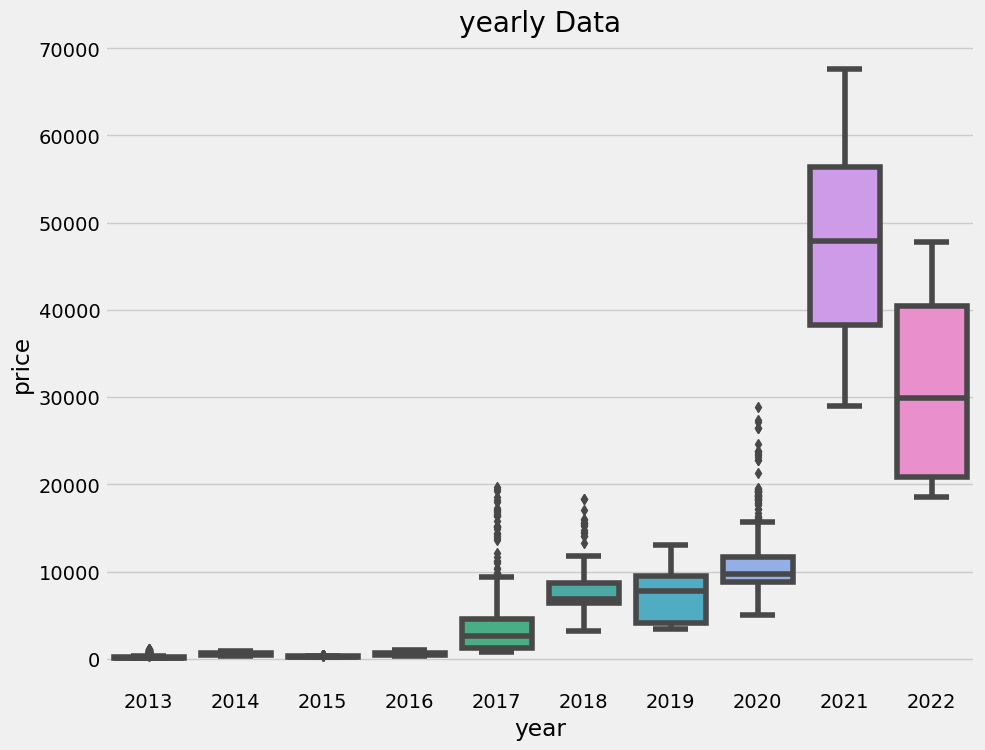

In [49]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='price')
ax.set_title('yearly Data')
plt.show()

In [72]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'price'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [73]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[20:00:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:4081.53247	validation_1-rmse:29072.27148
[100]	validation_0-rmse:1805.09595	validation_1-rmse:25016.09766
[200]	validation_0-rmse:940.53662	validation_1-rmse:23751.14062
[300]	validation_0-rmse:548.94226	validation_1-rmse:23353.65039


C:\Users\sagap\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[400]	validation_0-rmse:418.04819	validation_1-rmse:23221.56836
[500]	validation_0-rmse:380.07825	validation_1-rmse:23165.85742
[600]	validation_0-rmse:355.80734	validation_1-rmse:23142.30273
[700]	validation_0-rmse:335.04413	validation_1-rmse:23134.88672
[800]	validation_0-rmse:312.22916	validation_1-rmse:23135.56641
[900]	validation_0-rmse:297.25500	validation_1-rmse:23134.56250
[999]	validation_0-rmse:281.63190	validation_1-rmse:23141.46680


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

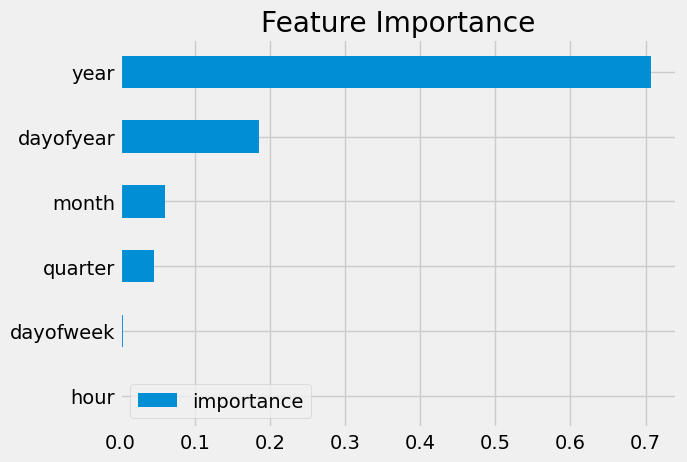

In [74]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=FEATURES,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

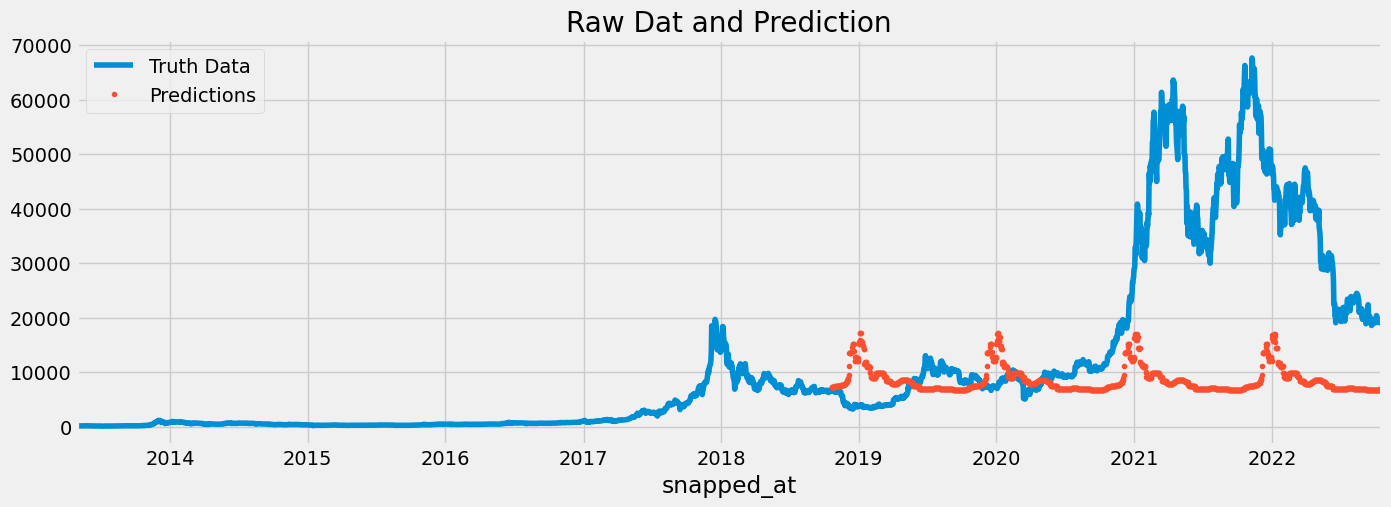

In [77]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['price']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [79]:
score = np.sqrt(mean_squared_error(test['price'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 23141.47
